# Apêndice A.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

## Importações.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sys
import PIL
import PIL.Image
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

gpu = tf.test.gpu_device_name()
if gpu == '':
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2021-09-18 15:06:45.773852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-18 15:06:45.773924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-18 15:06:48.255869: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-18 15:06:48.259852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-18 15:06:48.259883: W tensorflow/stream_ex

## Treinar/Carregar

In [3]:
flag = 1 #treinar modelo
#flag = 0 #carregar modelo !! (Comente para treinar e salvar)

## Configurações.

In [4]:
input_shape = (160,160,3)
batch = 256

vagas = 40
pontos = vagas*4

## Importação do Dataset.

In [5]:
BASE_PATH = ['../..','datasets']
DATASET_DIR=['PKLot','UFPR05']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],
                           DATASET_DIR[0],DATASET_DIR[1])
DATASET_DIR

'../../datasets/PKLot/UFPR05'

In [6]:
IMAGE_DIR = os.path.join(DATASET_DIR,'todas')
XML_DIR = IMAGE_DIR


IMAGE_LIST = []
XML_LIST = []
def criarLista():
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".jpg"):

            file = os.path.join(IMAGE_DIR,file)
            IMAGE_LIST.append(file)
    IMAGE_LIST.sort()

    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".xml"):

            file = os.path.join(XML_DIR,file)
            XML_LIST.append(file)
    XML_LIST.sort()


criarLista()
#debug
print(IMAGE_DIR)
print(XML_DIR)
print(IMAGE_LIST[:2])
print(XML_LIST[:2])

../../datasets/PKLot/UFPR05/todas
../../datasets/PKLot/UFPR05/todas
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.jpg', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.jpg']
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.xml', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.xml']


In [7]:
BASE_PATH = ['../..','datasets']
DATASET_DIR=['PKLot','UFPR05']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],
                           DATASET_DIR[0],DATASET_DIR[1])

DADOS_DIR = os.path.join(DATASET_DIR,'output')
X = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'validation')

class_names = X.class_names


print('\nClasses: {} em {}'.format(X.class_names,DADOS_DIR))

Found 166080 files belonging to 2 classes.
Using 116256 files for training.
Found 166080 files belonging to 2 classes.
Using 49824 files for validation.

Classes: ['livre', 'ocupada'] em ../../datasets/PKLot/UFPR05/output


In [8]:
val_batches = tf.data.experimental.cardinality(X_val)
X_test = X_val.take(val_batches // 5)
X_val  = X_val.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(X_val))
print('Number of test batches: %d' % tf.data.experimental.cardinality(X_test))



Number of validation batches: 156
Number of test batches: 39


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

X = X.prefetch(buffer_size=AUTOTUNE)
X_val = X_val.prefetch(buffer_size=AUTOTUNE)
X_test = X_test.prefetch(buffer_size=AUTOTUNE)

## Pre-processamento dos dados.

## Testando os Labels carregadas da base de treinamento.

2021-09-18 15:06:54.971608: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


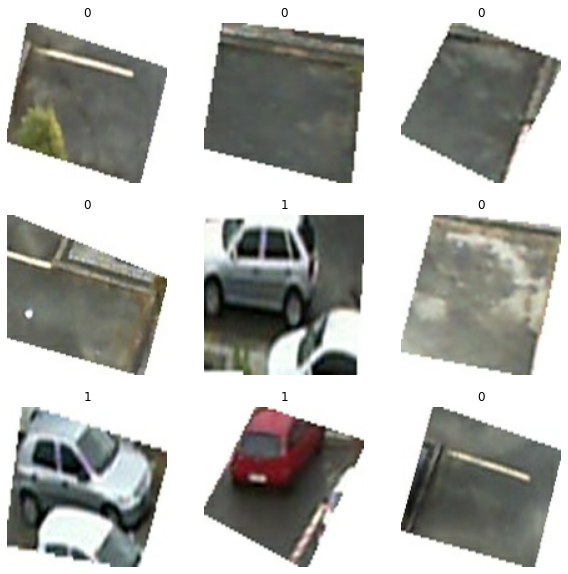

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in X_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
X.take(2)

<TakeDataset shapes: ((None, 160, 160, 3), (None, 1)), types: (tf.float32, tf.float32)>

### Exemplo de Imagem não segmentada.

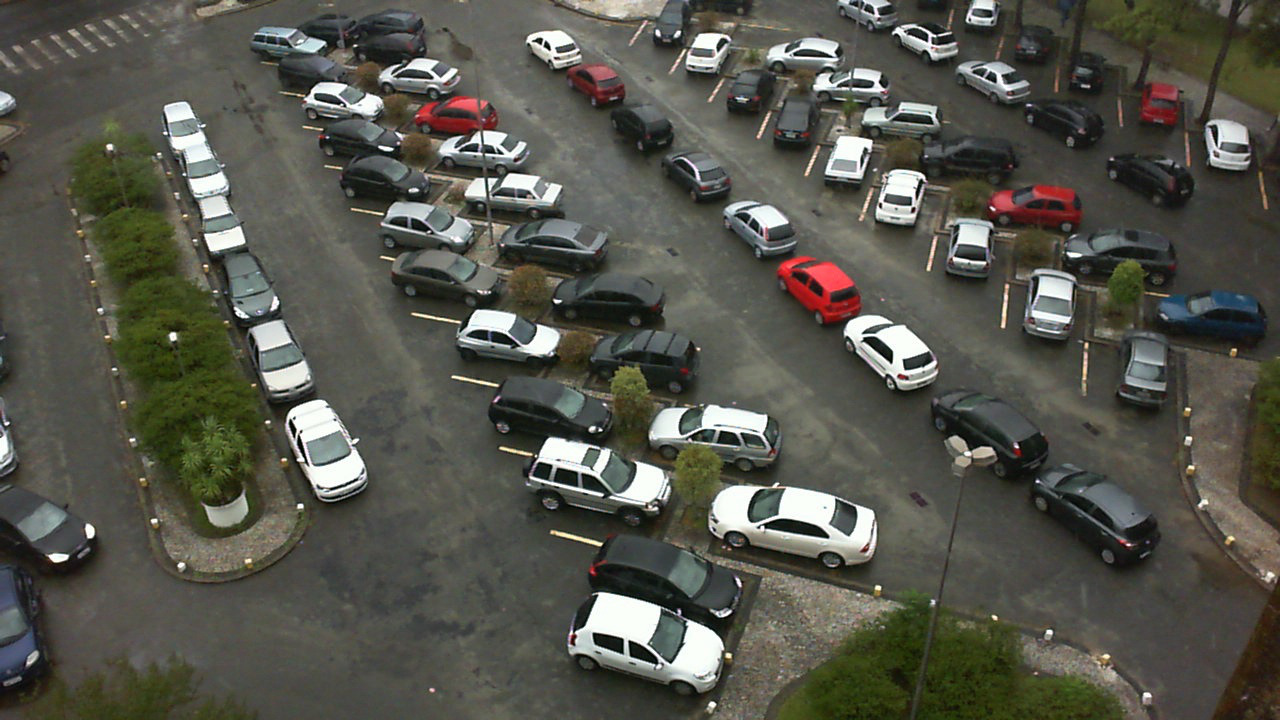

In [11]:
sort = np.random.randint(len(IMAGE_LIST))

PIL.Image.open(IMAGE_LIST[sort])

## Transfer Learning

### Normalizar as imagens para o padrão do modelo da mobilenet_v2

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [13]:
image_batch, label_batch = next(iter(X))

image_batch[1].shape

TensorShape([160, 160, 3])

### Criar o modelo base.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
#base_model.summary()



## Construindo o modelo e compilando.

In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
#x = preprocess_input(inputs)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(inputs)
x = base_model(x, training=False) # O modelo contem uma camada de Normalização. Não destruir os pesos aprendidos
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# def modelo():
#     model = keras.Sequential(
#     [
#         layers.InputLayer(input_shape),
#         layers.Conv2D(filters=32,kernel_size=5,strides=2, activation="relu"),
#         layers.Conv2D(32, 3, activation="relu"),
#         layers.MaxPooling2D(pool_size=3),
#         layers.BatchNormalization(),
        
#         layers.Conv2D(32,3, activation="relu"),
#         layers.Conv2D(32,3, activation="relu"),
#         layers.MaxPooling2D(2),
#         layers.BatchNormalization(),
        
#         layers.Flatten(),
#         layers.Dense(48,activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(48,activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(1, activation="sigmoid"),
#     ]
# )

#     return model

# #model = modelo()

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.summary()
# keras.utils.plot_model(model, "./images/arquitetura.png", show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_______________________________________________

## Treinando o modelo.

In [16]:
%%time

if flag:
    
#     loss0, accuracy0 = model.evaluate(X_val)
    
#     print("initial loss: {:.2f}".format(loss0))
#     print("initial accuracy: {:.2f}".format(accuracy0))
    
    history = model.fit(X, epochs=20, validation_data=X_val)
    
    
else:
    #LOAD_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    LOAD_DIR = os.path.join(DATASET_DIR,'model')

    model = keras.models.load_model(LOAD_DIR)
    

Epoch 1/20
455/455 [==============================] - 1015s 2s/step - loss: 0.2901 - accuracy: 0.8823 - val_loss: 0.0918 - val_accuracy: 0.9860
Epoch 2/20
455/455 [==============================] - 1008s 2s/step - loss: 0.0725 - accuracy: 0.9862 - val_loss: 0.0476 - val_accuracy: 0.9917
Epoch 3/20
455/455 [==============================] - 1014s 2s/step - loss: 0.0446 - accuracy: 0.9906 - val_loss: 0.0340 - val_accuracy: 0.9929
Epoch 4/20
455/455 [==============================] - 1010s 2s/step - loss: 0.0339 - accuracy: 0.9923 - val_loss: 0.0272 - val_accuracy: 0.9938
Epoch 5/20
455/455 [==============================] - 1013s 2s/step - loss: 0.0275 - accuracy: 0.9935 - val_loss: 0.0232 - val_accuracy: 0.9944
Epoch 6/20
455/455 [==============================] - 1019s 2s/step - loss: 0.0237 - accuracy: 0.9942 - val_loss: 0.0207 - val_accuracy: 0.9947
Epoch 7/20
455/455 [==============================] - 1016s 2s/step - loss: 0.0214 - accuracy: 0.9948 - val_loss: 0.0191 - val_accuracy:

## Métricas

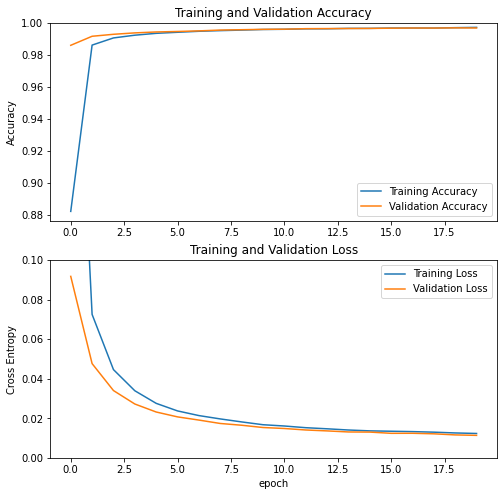

In [17]:
if flag:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,0.1])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Validação do modelo treinado. (testando na base de dados de validação)

In [18]:
%time
if flag:
    score = model.evaluate(X_test, verbose=2)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
39/39 - 65s - loss: 0.0112 - accuracy: 0.9970
Test loss: 0.011201534420251846
Test accuracy: 0.996995210647583


## Salvando o modelo treinado.

In [19]:
if flag:
    SAVE_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    SAVE_DIR = os.path.join(DATASET_DIR,'model')
    model.save(
        SAVE_DIR,
        overwrite=False,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )

[WARNING] ../../datasets/PKLot/UFPR05/model already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!


2021-09-15 09:52:20.130259: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../datasets/PKLot/UFPR05/model/assets


/home/pedrodsk/tcc_env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Validação individual (random) na base de treinamento

In [33]:
X = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'validation')

Found 166080 files belonging to 2 classes.
Using 116256 files for training.
Found 166080 files belonging to 2 classes.
Using 49824 files for validation.


Vaga livre: 99.92 porcento.
Vaga ocupada 0.08 porcento.


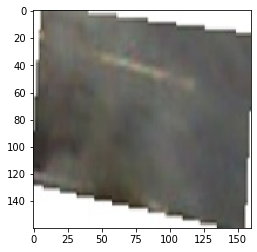

In [38]:
path = X.file_paths[np.random.randint(len(X.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)

#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1)

score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

plt.imshow(img)

## Validação individual (random) no Banco de testes

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs
Vaga livre: 0.00 porcento.
Vaga ocupada 100.00 porcento.


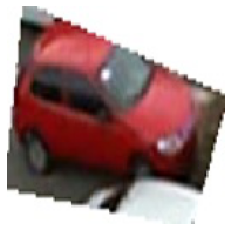

In [41]:
%time
path = X_val.file_paths[np.random.randint(len(X_val.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)
#predictions = model.call(img_array)

#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1)

score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)
plt.axis("off")
plt.imshow(img)
#PIL.Image.open(path)

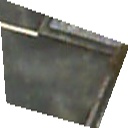

In [23]:
PIL.Image.open(path)

In [24]:
type(model.predict(img_array))

numpy.ndarray

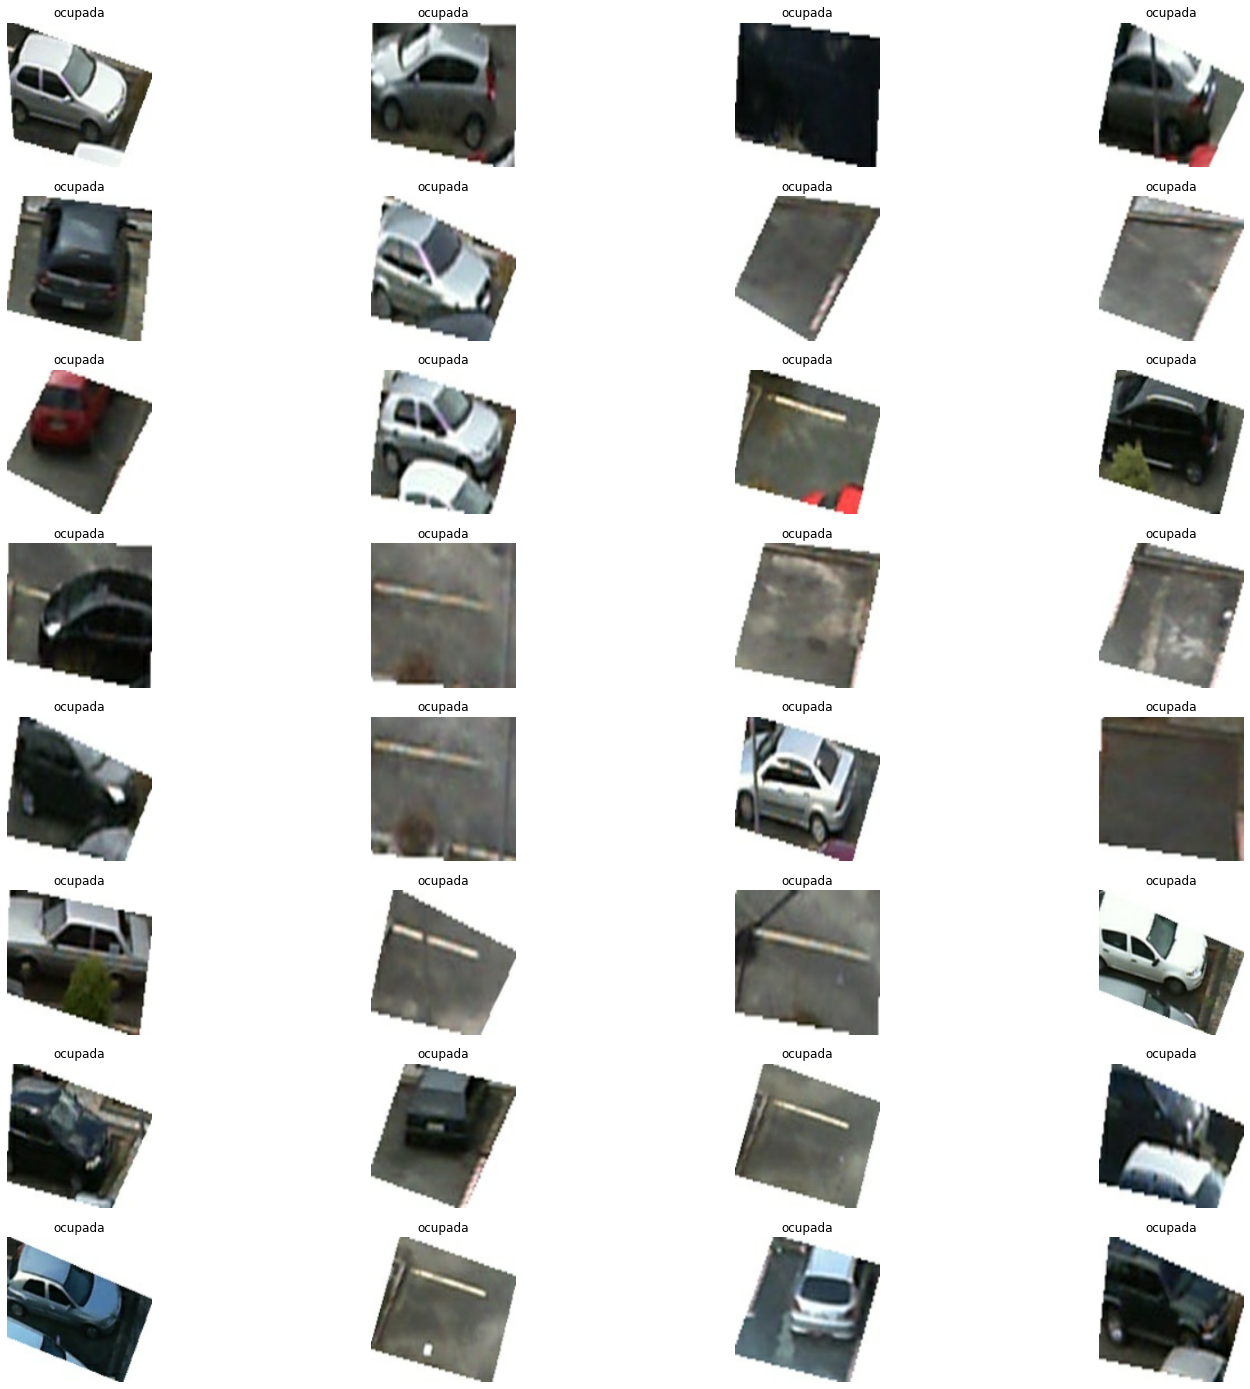

In [44]:
#Retrieve a batch of images from the test set
image_batch, label_batch = X_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

for i in range (len(predictions)):
    #print('\nPredictions = {}, {} = Label'.format(predictions[i].numpy(),label_batch[i].tolist()))
    pass

plt.figure(figsize=(25, 25))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## CARREGANDO XML E CRIANDO OS PONTOS

In [45]:
tree = ET.parse(XML_LIST[0])
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    #print(neighbor.attrib)
    if(len(neighbor.attrib.values())==2):
        _,occupied = neighbor.attrib.values()
        occupied = int(occupied)
    if(len(neighbor.attrib.values())==1):
        occupied=0
        
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:4])
print(vaga[0:40])

paresXY = np.array(np.zeros((pontos,2)),np.int32) 
j=0
for i in range(pontos):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:4]

[608 613 741 654]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


array([[608, 613],
       [741, 654],
       [775, 582],
       [608, 526]], dtype=int32)

In [46]:
def crop(j=0,i=0):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, input_shape[:2], interpolation = cv2.INTER_CUBIC)
    
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,  0)

    predictions = model.predict(img_array)
     
    score = predictions[0]
    score = float(score)
    return score
    

In [47]:
def juntar(im2,im,scale=80):
    
    img = np.hstack((im2, im))
    
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)  
    return resized

## Defina o número de Vagas (0-37)

In [57]:
nVagas = 40
nVagas = vagas - nVagas

## Varias imagens.

In [58]:
for i in range (3): #só repetição
    
    sort = np.random.randint(len(IMAGE_LIST))
    im = cv2.imread(IMAGE_LIST[sort])
    im2 = im.copy()
    if im is None:
        sys.exit("A imagem não foi carregada.")

    j=0
    contador = 0
    for i in range(nVagas,len(paresXY)//4):

        score = crop(j,i)
        #print(score)
        if((score)<0.7):
            cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
            contador = contador +1
            #print(score)
        j=j+4
        
        

    cv2.putText(im,str(contador),(10,700), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5,cv2.LINE_AA)
    img_junta = juntar(im2,im,70)

    cv2.imshow(IMAGE_LIST[sort], img_junta)
    k = cv2.waitKey(0)
    cv2.destroyAllWindows()
# if k == ord('q'):
#     cv2.destroyAllWindows()

#image = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#plt.imshow(image)

## VIDEO

In [60]:
VIDEO_FILE = os.path.join(DATASET_DIR,'pklot.mp4')
cap = cv2.VideoCapture(VIDEO_FILE)

if cap.isOpened() == False:
    print('Video não encontrado.')

while(cap.isOpened()):
    ret, im = cap.read()
    height, width, _ = im.shape
    
    if ret == True:
    
        j=0
        contador = 0
                
    
        for i in range(nVagas,len(paresXY)//4):
            
            score = crop(j,i)
            #print(score)
            if((score)<0.7):
                cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
                contador = contador +1
                #print(score)
            j=j+4
        
        cv2.putText(im,str(contador),(10,700), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5,cv2.LINE_AA)
        cv2.imshow('Estacionamento', im)
        
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    
    else:
        break
cap.release()
cv2.destroyAllWindows()

## Debug 

(-0.5, 1279.5, 719.5, -0.5)

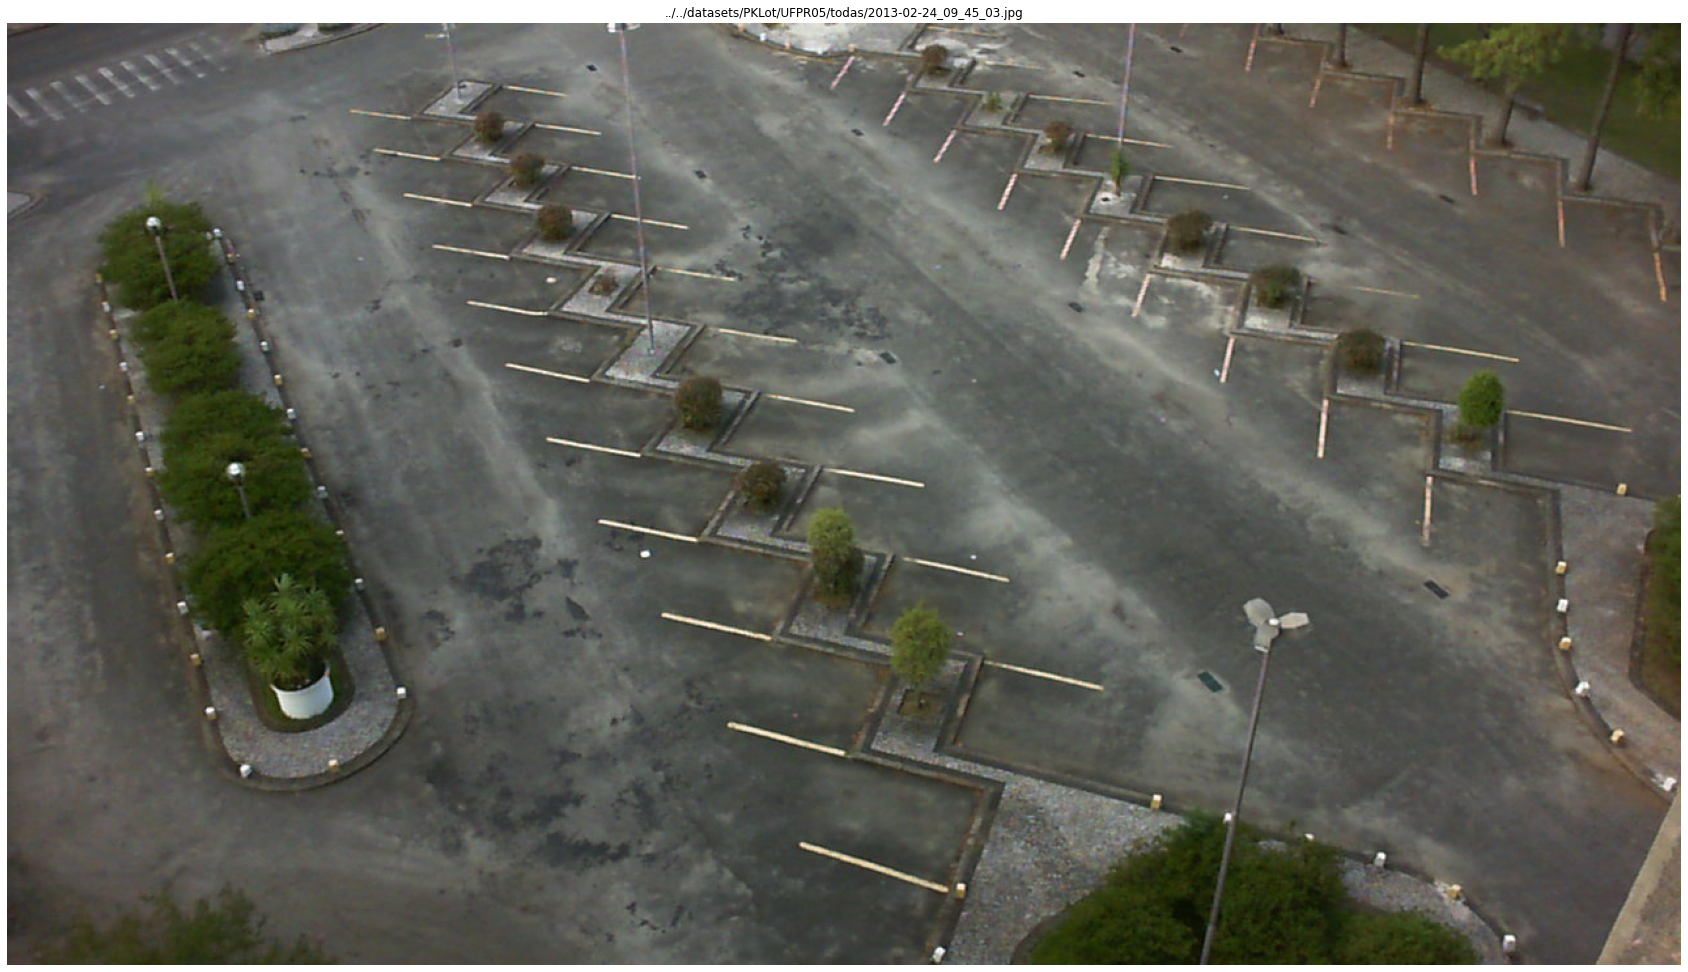

In [32]:
im = plt.imread(IMAGE_LIST[450])
j=0
contador = 0
for i in range(nVagas,len(paresXY)//4):

    score = crop(j,i)
    #print(score)
    if((score)<0.0):
        cv2.polylines(im,[paresXY[j:j+4]],True,(255,255,0),2)
        contador = contador +1
        #print(score)
    j=j+4

fig = plt.figure(figsize=(30, 30))
#image = plt.imread(IMAGE_LIST[350])
#im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.title(IMAGE_LIST[350])
plt.axis("off")

In [11]:
import time
a = time.strftime("%d-%m-%Y")
a

'17-09-2021'